## Introduction

Now that we have plotted our first scWGS power spectral densities, let's estimate the amplicon size distribution from these data. This notebook walks you through how to perform this estimation. It also includes plots of simulation data generated in the accompanying notebook to show the goodness of the estimation and how the estimation procedure can be used to compare two different MDA protocols

This notebook demonstrates the use of the ```amplicon.AmplDist()``` class, which is fundamentally responsible for amplicon distribution estimation. However, convenience functions to perform these analyses (and mask the technical detais) are included as part of the ```PSDTools.SamplePSD()``` class. Use of these functions is demonstrated in ```05_example_chromosome_classification```.

In [1]:
import pandas as pd
import numpy as np
import scipy.optimize
import scipy.special
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib
import sys

import PaSDqc

%matplotlib inline

Load data using PaSDqc API

In [2]:
sample_mda = PaSDqc.PSDTools.SamplePSD.load_from_file("../data/intro_PSDs/example_MDA.spec", name='MDA')
sample_malbac = PaSDqc.PSDTools.SamplePSD.load_from_file("../data/intro_PSDs/example_MALBAC.spec", name='MALBAC')
# sample_bulk = PaSDqc.PSDTools.SamplePSD(pd.read_table("../example_02-basic_PSD/example_bulk.spec", index_col=0), name='Bulk')

In [3]:
freq = sample_mda.freq
avg_mda = sample_mda.avg_PSD()
# avg_bulk = sample_bulk.avg_PSD()
avg_malbac = sample_malbac.avg_PSD()

Load normalization file included in PaSDqc package

In [4]:
f_norm = PaSDqc.extra_tools.get_data_file('bulk_1x.smooth3.spec')
norm = pd.Series.from_csv(f_norm, index_col=0, sep="\t").as_matrix()

Fit the amplicon distribution curves using the erf method (other available methods include "logis" and "gamma")

In [5]:
ampl_dist_mda = PaSDqc.amplicon.AmplDist(freq, avg_mda)
ampl_dist_mda.fit_curve(method='erf')
popt_erf_mda = ampl_dist_mda.popt['erf'][0:4]

ampl_dist_malbac = PaSDqc.amplicon.AmplDist(freq, avg_malbac)
ampl_dist_malbac.fit_curve(method='erf')
popt_erf_malbac = ampl_dist_malbac.popt['erf'][0:4]

Estimate amplicon median, mean, and bounds using Monte Carlo simulation

In [6]:
median_mda, mean_mda, lower_95_mda, upper_95_mda = ampl_dist_mda.amplicon_range(method='erf')
median_mal, mean_mal, lower_95_mal, upper_95_mal = ampl_dist_malbac.amplicon_range(method='erf')

Estimate the amplicon size density

In [7]:
pdf_erf_mda = ampl_dist_mda.amplicon_dist()
pdf_erf_mal = ampl_dist_malbac.amplicon_dist()

Normalize PSDs for plotting purposes

In [8]:
psd_mda = PaSDqc.PSDTools.normalize_psd(avg_mda)
psd_malbac = PaSDqc.PSDTools.normalize_psd(avg_malbac)

Load simulation data generated in Ampl_dist_sim.ipynb

In [9]:
df_sim = pd.read_table("MDA_erf_sim.txt")

In [10]:
def normalize(freq, psd, norm, shift=0):
    normed = 10*np.log10(psd/norm) + shift
    
    return normed/np.max(normed)

In [11]:
freq_cut = freq[freq < 1e-3]
psd_30 = normalize(freq, avg_mda, norm, shift=-4)

In [12]:
freq_cut = freq[freq < 1e-3]
psd_30_3p = normalize(freq, sample_mda.df['3'], norm, shift=-0.75)

Load data protocol comparison data generated in Lodato_vs_Zhang_ampl_dist.ipynb

In [13]:
df_lodata = pd.read_table("Ampl_dist_lodato.txt")
df_cz = pd.read_table("Ampl_dist_CZ.txt")

Make a massive plot

In [14]:
sns.set_context('poster')
sns.set_style("ticks", {'ytick.minor.size': 0.0, 'xtick.minor.size': 0.0})

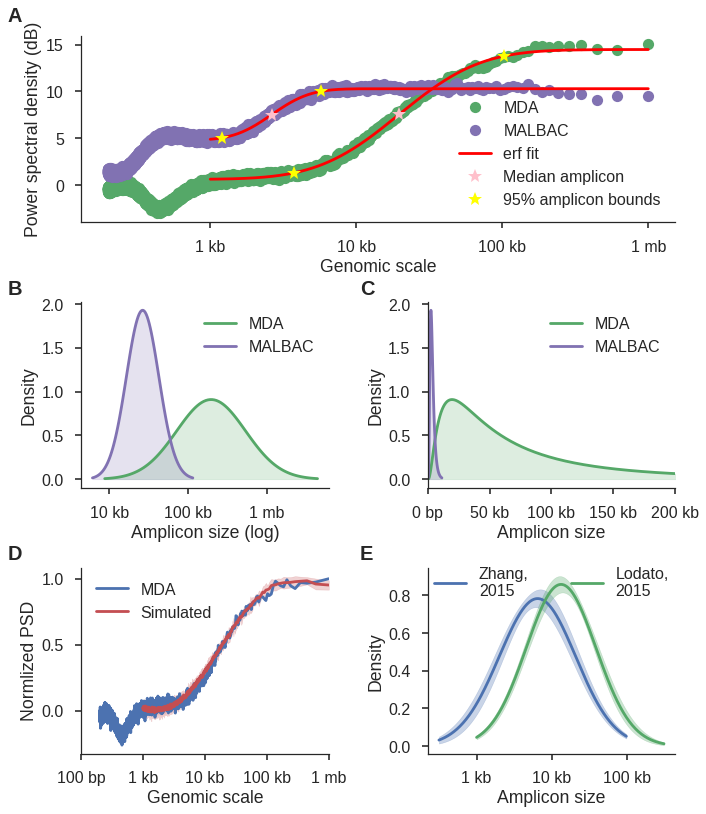

In [15]:
f = plt.figure(figsize=(10, 11.5))
cp = sns.color_palette()

# Spectral density and curve fits
ax0 = plt.subplot2grid((3, 2), (0, 0), colspan=2)
ax0.plot((0,0), (0,0))
ax0.plot(1/freq, psd_mda, 'o', label='MDA')
ax0.plot(1/freq, psd_malbac, 'o', label='MALBAC', color=cp[3])
ax0.plot(10**ampl_dist_mda.freq['erf'], ampl_dist_mda.func_erf(ampl_dist_mda.freq['erf'], *popt_erf_mda), color='red', label='erf fit')
ax0.plot(10**ampl_dist_malbac.freq['erf'], ampl_dist_malbac.func_erf(ampl_dist_malbac.freq['erf'], *popt_erf_malbac), color='red')

ax0.plot(median_mda, ampl_dist_mda.func_erf(np.log10(median_mda), *popt_erf_mda), '*', markersize=15, color='pink', label='Median amplicon')
ax0.plot(lower_95_mda, ampl_dist_mda.func_erf(np.log10(lower_95_mda), *popt_erf_mda), '*', markersize=15, color='yellow', label='95% amplicon bounds')
ax0.plot(upper_95_mda, ampl_dist_mda.func_erf(np.log10(upper_95_mda), *popt_erf_mda), '*', markersize=15, color='yellow')
ax0.plot(median_mal, ampl_dist_malbac.func_erf(np.log10(median_mal), *popt_erf_malbac), '*', markersize=15, color='pink')
ax0.plot(lower_95_mal, ampl_dist_malbac.func_erf(np.log10(lower_95_mal), *popt_erf_malbac), '*', markersize=15, color='yellow')
ax0.plot(upper_95_mal, ampl_dist_malbac.func_erf(np.log10(upper_95_mal), *popt_erf_malbac), '*', markersize=15, color='yellow')

ax0.legend(loc=4)
ax0.set_xscale('log')
ax0.set_xlabel('Genomic scale')
ax0.set_ylabel('Power spectral density (dB)')
ax0.set_xticklabels(["0", "100 bp", "1 kb", "10 kb", "100 kb", "1 mb"])

# Log distribution
ax1 = plt.subplot2grid((3, 2), (1, 0))
ax1.plot(ampl_dist_mda.freq['dist'], pdf_erf_mda, label='MDA', color=cp[1])
ax1.fill_between(ampl_dist_mda.freq['dist'], pdf_erf_mda, color=cp[1], alpha=0.2)
ax1.plot(ampl_dist_malbac.freq['dist'], pdf_erf_mal, label='MALBAC', color=cp[3])
ax1.fill_between(ampl_dist_malbac.freq['dist'], pdf_erf_mal, color=cp[3], alpha=0.2)

ax1.set_xlabel('Amplicon size (log)')
ax1.set_ylabel('Density')
ax1.legend()
ax1.set_xscale('log')
ax1.set_xticklabels(["100 bp", "1 kb", "10 kb", "100 kb", "1 mb"])

# Real distribution
ax2 = plt.subplot2grid((3, 2), (1, 1))
ax2.plot(ampl_dist_mda.freq['dist'], pdf_erf_mda, label='MDA', color=cp[1])
ax2.fill_between(ampl_dist_mda.freq['dist'], pdf_erf_mda, color=cp[1], alpha=0.2)

ax2.plot(ampl_dist_malbac.freq['dist'], pdf_erf_mal, label='MALBAC', color=cp[3])
ax2.fill_between(ampl_dist_malbac.freq['dist'], pdf_erf_mal, color=cp[3], alpha=0.2)

ax2.set_xlabel('Amplicon size')
ax2.set_ylabel('Density')
ax2.set_xlim(0, 2e5)
ax2.legend()
ax2.set_xticklabels(["0 bp", "50 kb", "100 kb", "150 kb", "200 kb"])

# Simulated fit
erf_avg = df_sim.avg
erf_se = df_sim.se
ax3 = plt.subplot2grid((3, 2), (2, 0), colspan=1)
ax3.plot(1/freq, psd_30_3p, label='MDA')
ax3.plot(1/freq_cut, erf_avg, label='Simulated', color=cp[2])
ax3.fill_between(1/freq_cut, erf_avg-2*erf_se, erf_avg+2*erf_se, alpha=0.25, color=cp[2])
ax3.set_xscale('log')
ax3.legend(loc='upper left')
ax3.set_ylabel('Normlized PSD')
ax3.set_xlabel('Genomic scale')
ax3.set_xlim(1e2, 1e6)
ax3.set_xticklabels(["0", "100 bp", "1 kb", "10 kb", "100 kb", "1 mb"])

# Lodato 2015 vs. Zhang 2015
pdf_alk_avg = df_lodata.avg
pdf_alk_std = df_lodata['std']
pdf_cz_avg = df_cz.avg
pdf_cz_std = df_cz['std']
freq_eval2 = np.arange(3, 5.5, 0.01)
freq_eval3 = np.arange(2.5, 5, 0.01)

ax4 = plt.subplot2grid((3, 2), (2, 1))
ax4.plot(10**freq_eval3, pdf_cz_avg, label='Zhang,\n2015')
ax4.fill_between(10**freq_eval3, pdf_cz_avg-pdf_cz_std, pdf_cz_avg+pdf_cz_std, alpha=0.3, color=cp[0])
ax4.plot(10**freq_eval2, pdf_alk_avg, label='Lodato,\n2015')#label='Alkaline\nlysis')
ax4.fill_between(10**freq_eval2, pdf_alk_avg-pdf_alk_std, pdf_alk_avg+pdf_alk_std, alpha=0.3, color=cp[1])

ax4.legend(bbox_to_anchor=(0., 0.8, 1., .102), loc=(0, 0), ncol=2, mode="expand", borderaxespad=0.)
ax4.set_xscale('log')
ax4.set_xlabel('Amplicon size')
ax4.set_ylabel('Density')
ax4.set_xticklabels(["0", "100 bp", "1 kb", "10 kb", "100 kb", "1 mb"])

# Figure layout
f.text(0.01, 0.98, "A", weight="bold", horizontalalignment='left', verticalalignment='center', fontsize=20)
f.text(0.01, 0.65, "B", weight="bold", horizontalalignment='left', verticalalignment='center', fontsize=20)
f.text(0.5, 0.65, "C", weight="bold", horizontalalignment='left', verticalalignment='center', fontsize=20)
f.text(0.01, 0.33, "D", weight="bold", horizontalalignment='left', verticalalignment='center', fontsize=20)
f.text(0.5, 0.33, "E", weight="bold", horizontalalignment='left', verticalalignment='center', fontsize=20)
plt.tight_layout()

sns.despine(fig=f, ax=ax0)